In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Div = Divisão da Liga
# Date = Data do jogo
# HomeTeam = Time da casa
# AwayTeam = Time visitante
# FTR = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# B365H = Odd (probablidade) de vitória do time da casa pela Bet365 (casa de apostas)
# B365D = Odd (probablidade) de empate pela Bet365 (casa de apostas)
# B365A = Odd (probablidade) de vitória do time visitante pela Bet365 (casa de apostas)
# BWH = Odd (probablidade) de vitória do time da casa pela Bet&Win (casa de apostas)
# BWD = Odd (probablidade) de empate pela Bet&Win (casa de apostas)
# BWA = Odd (probablidade) de vitória do time visitante pela Bet&Win (casa de apostas)
# IWH = Odd (probablidade) de vitória do time da casa pela Interwetten (casa de apostas)
# IWD = Odd (probablidade) de empate pela Interwetten (casa de apostas)
# IWA = Odd (probablidade) de vitória do time visitante pela Interwetten (casa de apostas)
# PSH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PSD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PSA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# VCH = Odd (probablidade) de vitória do time da casa pela VC Bet (casa de apostas)
# VCD = Odd (probablidade) de empate pela VC Bet (casa de apostas)
# VCA = Odd (probablidade) de vitória do time visitante pela VC Bet (casa de apostas)
# WHH = Odd (probablidade) de vitória do time da casa pela William Hill (casa de apostas)
# WHD = Odd (probablidade) de empate pela William Hill (casa de apostas)
# WHA = Odd (probablidade) de vitória do time visitante pela William Hill (casa de apostas)

# Lendo o arquivo FRA5anos.csv
data = pd.read_csv('FRA5anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,F1,04/08/17,Monaco,Toulouse,H,1.30,5.5,10.00,1.30,5.75,...,7.90,1.32,5.72,11.12,1.30,5.5,11.00,1.30,5.0,10.0
1,F1,05/08/17,Lyon,Strasbourg,H,1.36,5.0,8.50,1.36,5.00,...,7.50,1.40,5.19,8.99,1.36,5.0,9.00,1.40,4.5,8.0
2,F1,05/08/17,Metz,Guingamp,A,2.80,3.2,2.63,2.80,3.20,...,2.65,2.95,3.20,2.71,2.88,3.2,2.63,2.70,3.1,2.7
3,F1,05/08/17,Montpellier,Caen,H,1.91,3.5,4.20,1.83,3.60,...,4.10,1.88,3.54,4.74,1.90,3.5,4.40,1.91,3.2,4.5
4,F1,05/08/17,Paris SG,Amiens,H,1.11,9.0,25.00,1.12,9.25,...,14.00,1.13,10.70,26.00,1.12,9.5,19.00,1.10,9.0,26.0


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["FTR"][i] == "D":
        data.at[i,"FTR"] = "0"
    if data["FTR"][i] == "H":
        data.at[i,"FTR"] = "1"
    if data["FTR"][i] == "A":
        data.at[i,"FTR"] = "2"

data["FTR"] = data["FTR"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,1,F1,04/08/17,Monaco,Toulouse,1,1.30,5.5,10.00,1.30,...,7.90,1.32,5.72,11.12,1.30,5.5,11.00,1.30,5.0,10.0
1,2,F1,05/08/17,Lyon,Strasbourg,1,1.36,5.0,8.50,1.36,...,7.50,1.40,5.19,8.99,1.36,5.0,9.00,1.40,4.5,8.0
2,3,F1,05/08/17,Metz,Guingamp,2,2.80,3.2,2.63,2.80,...,2.65,2.95,3.20,2.71,2.88,3.2,2.63,2.70,3.1,2.7
3,4,F1,05/08/17,Montpellier,Caen,1,1.91,3.5,4.20,1.83,...,4.10,1.88,3.54,4.74,1.90,3.5,4.40,1.91,3.2,4.5
4,5,F1,05/08/17,Paris SG,Amiens,1,1.11,9.0,25.00,1.12,...,14.00,1.13,10.70,26.00,1.12,9.5,19.00,1.10,9.0,26.0


Total de jogos:  1789
Total de colunas:  24
Total de jogos ganhos em casa:  771
Total de jogos ganhos pelo visitante:  549
Total de jogos empatados:  469
Percentual de jogos ganhos em casa: 43.10%


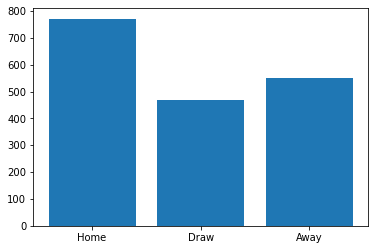

In [5]:
# Explorando a base de dados de dos campeonatos de 2017/2018 a 2021/2022 (últimas 5 temporadas completas)

# Na temporada 2019/2020 devido a pandemia de Covid-19 o campeonato foi encerrado com 10 rodadas de antecedência e...
#...também ficou faltando o jogo de conclusão da 28ª rodada entre o Strasbourg e o Paris Saint-Germain...
# Totalizando 279 partidas neste campeonato em relação aos 380 jogos dos demais anos.

# Além disso 10 linhas da base de dados foram retiradas por falta de algumas informações necessárias de variáveis

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.FTR==1])
away_win = len(data[data.FTR==2])
draw = len(data[data.FTR==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']]
labels = data['FTR']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
   B365H  B365D  B365A   BWH   BWD    BWA   IWH  IWD    IWA   PSH    PSD  \
0   1.30    5.5  10.00  1.30  5.75   9.75  1.35  4.7   7.90  1.32   5.72   
1   1.36    5.0   8.50  1.36  5.00   8.50  1.40  4.3   7.50  1.40   5.19   
2   2.80    3.2   2.63  2.80  3.20   2.65  2.65  3.1   2.65  2.95   3.20   
3   1.91    3.5   4.20  1.83  3.60   4.50  1.85  3.4   4.10  1.88   3.54   
4   1.11    9.0  25.00  1.12  9.25  21.00  1.17  6.5  14.00  1.13  10.70   

     PSA   VCH  VCD    VCA   WHH  WHD   WHA  
0  11.12  1.30  5.5  11.00  1.30  5.0  10.0  
1   8.99  1.36  5.0   9.00  1.40  4.5   8.0  
2   2.71  2.88  3.2   2.63  2.70  3.1   2.7  
3   4.74  1.90  3.5   4.40  1.91  3.2   4.5  
4  26.00  1.12  9.5  19.00  1.10  9.0  26.0  
Labels
0    1
1    1
2    2
3    1
4    1
Name: FTR, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (1789, 18)
[[0.01253133 0.26923077 0.26985093 ... 0.01352028 0.21875    0.22305764]
 [0.01553885 0.23076923 0.22421661 ... 0.01852779 0.1796875  0.17293233]
 [0.0877193  0.09230769 0.04563432 ... 0.08362544 0.0703125  0.04010025]
 ...
 [0.07769424 0.11538462 0.04533009 ... 0.07611417 0.1015625  0.03809524]
 [0.0075188  0.5        0.26985093 ... 0.00851277 0.375      0.27318296]
 [0.14786967 0.13461538 0.02190447 ... 0.14872308 0.125      0.01754386]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:1430]     representa aproximadamente 80% dos dados
# Teste [1430:1610]      representa aproximadamente 10% dos dados
# Previsão [1610:1789]     representa aproximadamente 10% dos dados


X_train = features_scale[:1430]
X_test = features_scale[1430:1610]
y_train = labels[:1430]
y_test = labels[1430:1610]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1430 1430
180 180


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 50.56%
F1 Score: 50.56%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 50.00%
F1 Score: 50.00%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 37.78%
F1 Score: 36.85%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 38.89%
F1 Score: 38.89%


In [13]:
#Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[1610:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[1610:]

res_full = data['FTR']
res_prev = res_full[1610:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
1610     2         1     1611
1611     1         1     1612
1612     2         2     1613
1613     0         1     1614
1614     2         2     1615
...    ...       ...      ...
1784     0         1     1785
1785     1         1     1786
1786     0         1     1787
1787     1         1     1788
1788     2         2     1789

[179 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

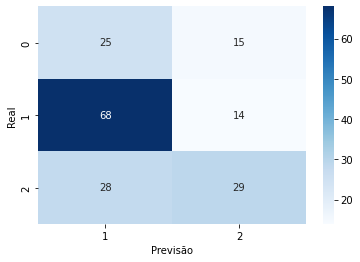

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')